<a href="https://colab.research.google.com/github/Jack3690/Lily/blob/main/Light_curves_using_Lightkurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve --quiet

     |████████████████████████████████| 247 kB 7.6 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 
     |████████████████████████████████| 4.5 MB 30.2 MB/s 
     |████████████████████████████████| 41 kB 174 kB/s 
     |████████████████████████████████| 832 kB 56.9 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 3.6 MB 45.9 MB/s 


In [24]:
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d


In [3]:
!git clone https://github.com/Srivardini11/lark

Cloning into 'lark'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 147 (delta 49), reused 0 (delta 0), pack-reused 34
Receiving objects: 100% (147/147), 7.48 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [4]:
with open('lark/data/Fabienne.txt',mode='r') as f:
  dat = f.readlines()
  f.close()
col_names = dat[5].split()[1:]

data = []
for i in dat[6:]:
  data.append([float(j) for j in i.split()])

df = pd.DataFrame(data, columns=col_names)
df

,KepID,KepMag,Teff(SDSS),F_8(Corr),R(Corr),Zcross
0,1164109.0,10.88,6607.0,0.0630,3.68,27.0
1,1725815.0,10.83,6550.0,0.0497,0.28,75.0
2,1868918.0,11.56,6252.0,0.0470,0.43,84.0
3,2010835.0,11.33,6103.0,0.0530,0.14,245.0
4,2013883.0,11.21,6278.0,0.0556,0.48,32.0
...,...,...,...,...,...,...
537,12555505.0,9.62,5704.0,0.0298,0.29,49.0
538,12600459.0,10.41,6303.0,0.0409,0.43,93.0
539,12602236.0,10.15,6522.0,0.0447,0.89,65.0
540,12690331.0,11.48,6626.0,0.0668,0.51,67.0


In [55]:
 flkr_list   = []
 source_list = []
 logg_list   = []
 for id in ['5449910'] :
  # Data acquisition
  source = lk.search_lightcurve(f"kplr{str(int(id))}", author="Kepler", cadence="long",quarter = 9).download().remove_nans() 
  source_list.append(source)
  logg_list.append(source.logg)
  # Transit Removal
  transit_lc = source.remove_outliers(sigma =2.5)

  # Second order Spine fitting
  flatten_lc, trend_lc = transit_lc.flatten(window_length=101, polyorder=2, sigma=2.5,return_trend=True)
  out = transit_lc - trend_lc
  flux = out.flux.value
  time = out.time.value
  
  # interpolation
  flux_new_f = interp1d(time,flux)
  time_new = np.linspace(time.min(), time.max(), int((time.max() - time.min())*48))
  flux_new = flux_new_f(time_new)

  # Boxcar smoothening
  smoothed_signal = convolve(flux_new, Box1DKernel(16))
  box_sub = flux_new - smoothed_signal

  # Flicker
  flk_rms = np.sqrt((box_sub**2).mean())

  flkr_list.append(flk_rms/1000)

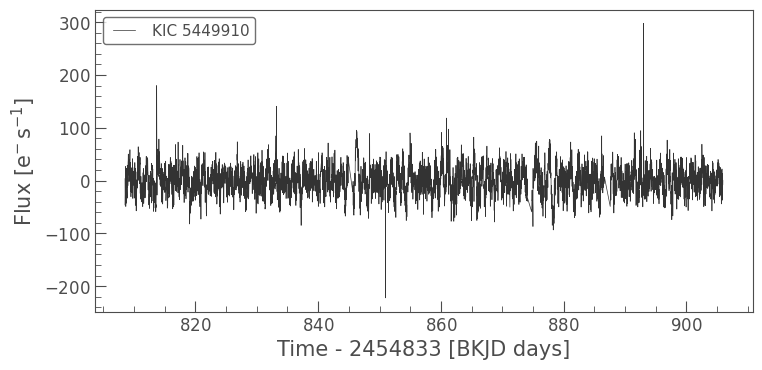

In [54]:
out.plot()

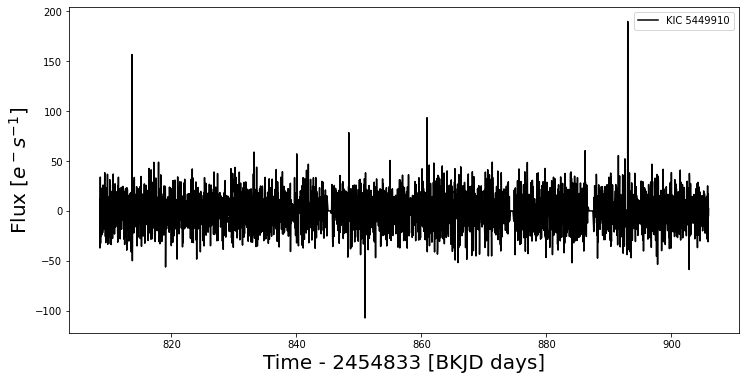

In [63]:
plt.figure(figsize = (12,6))
plt.plot(time_new,box_sub, color = 'black')
plt.xlabel('Time - 2454833 [BKJD days]',fontsize =20)
plt.ylabel('Flux ' + r'$[e^-s^{-1}]$',fontsize =20)
plt.legend(['KIC 5449910'])

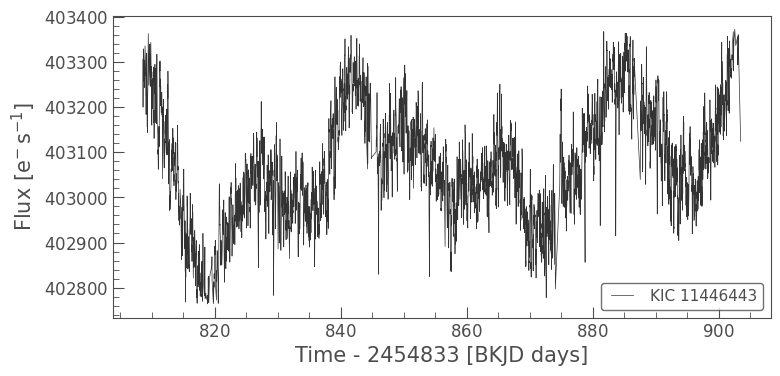

In [48]:
transit_lc.plot()

In [11]:
df['F_8(Calculated)'] = flkr_list
df['LogG']            = logg_list

(5.0, 2.5)

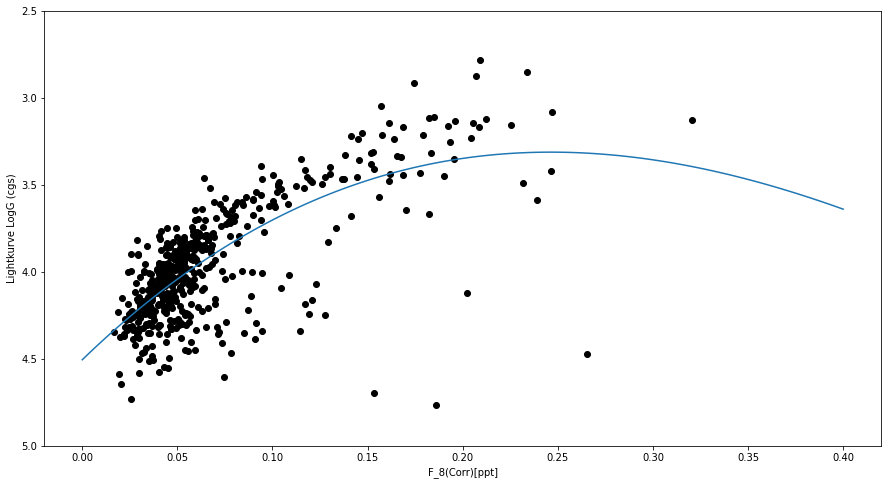

In [33]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
ax.scatter(df['F_8(Corr)'],df.LogG , color = 'black')
ax.invert_yaxis()
ax.set_xlabel('F_8(Corr)[ppt]')
ax.set_ylabel('Lightkurve LogG (cgs)')

init = models.Polynomial1D(3)
fit  = fitting.LevMarLSQFitter()
model = fit(init,df['F_8(Corr)'].values, df.LogG.values)
x = np.linspace(0,0.4,100)
y = model(x)
ax.plot(x,y)

ax.set_ylim(5,2.5)

Text(0, 0.5, '$Log_{10}$ $R_{var}$')

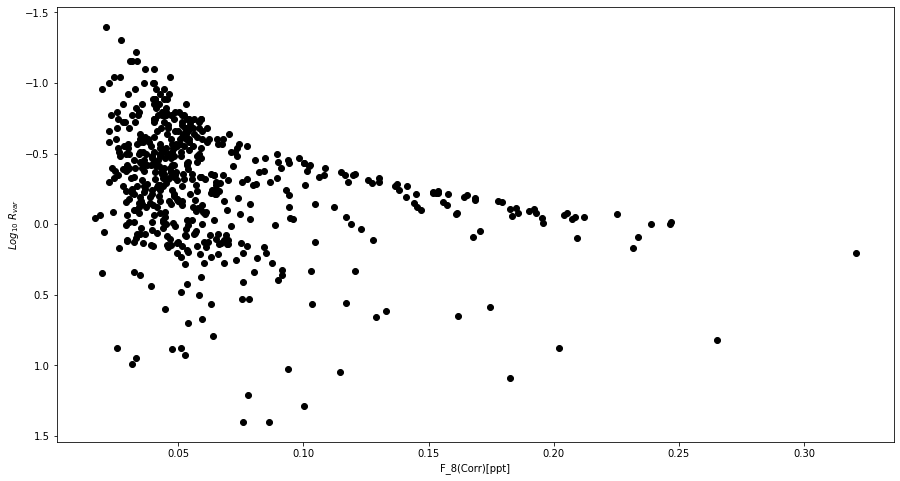

In [67]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
ax.scatter(df['F_8(Corr)'], np.log10(df['R(Corr)'].values), color = 'black')
ax.invert_yaxis()
ax.set_xlabel('F_8(Corr)[ppt]')
ax.set_ylabel(r'$Log_{10}$ ' + r'$R_{var}$')

Text(0, 0.5, '$\\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')

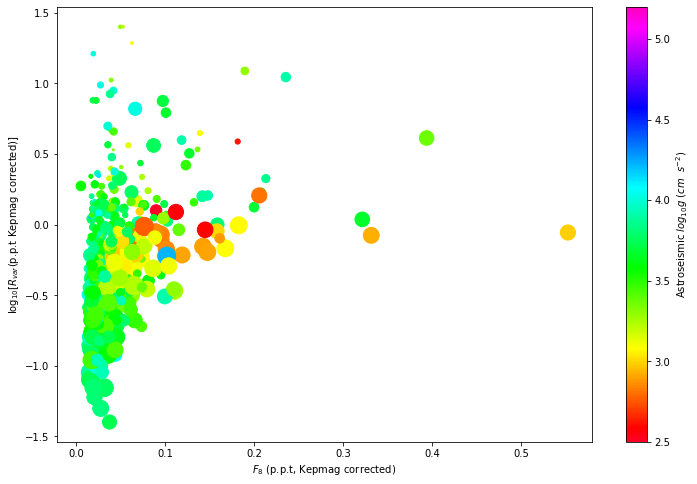

In [134]:
|x = df['F_8(Calculated)']
y = np.log10(df['R(Corr)'])
c = df['LogG']
s = df['Zcross']
plt.figure(figsize = (12,8))
img = plt.scatter(x,y,c=c*0.9,s=s*1.5,cmap='gist_rainbow',vmin=2.5,vmax=5.2)
plt.colorbar(img,label=r'Astroseismic $log_{10}g$ ($cm$  $s^{-2}$)')
plt.xlabel(r'$F_8$ (p.p.t, Kepmag corrected)')
plt.ylabel(r'$\log_{10}[R_{var}$(p.p.t Kepmag corrected)]')